<h1>Churn Project:Tuning Hyper Parameters</h1>

The original Jupyter Notebook for this project was an assignement for the Udacity Nano Degree in Data Science Program. As part of the project, I had to create a submit a blog post which can be found <a href='https://james-r-bishop.medium.com/introduction-to-machine-learning-a-beginners-take-88ae1513594f'>here</a>. In this notebook, I intend to explore tuning hyper parameters using <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html'>GridSearchCV</a> and <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html?highlight=randomizedsearchcv#sklearn.model_selection.RandomizedSearchCV'>RandomizedSearchCV</a> as part of this exploration. 

<h2>Defining the Problem</h2>

Now that I have implemented and baselined some models, I am curious to see if they can be tuned to increase performance. The good news is I have already finished all the ingest and conditioning so none of that needs to change. For this, I can focus on trying to make the two methods work, look to see if there are others, and see if this is worth the effort. 

<h2>Ingest and Initial Conditioning</h2>

This was lifted directly from my earlier project. All of the explanations for the below transformations are in that notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import r2_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics, svm, tree
import seaborn as sns
%matplotlib inline

# This section is to beautify this Notebook by surpressing warnings that aren't important
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

def make_column_ones_zeroes(col, input_list):
    '''
    Input: 
    col=column being worked on, only works on one column at a time
    input_list=values in the original column, the index of the value will be the int replacing the value
    
    Output:
    None. The transformation is done inplace
    '''
    for input in input_list:
        df[col][df[col]==input]=input_list.index(input)
    df[col]=pd.to_numeric(df[col])
    return

def recast_column_type(columns,column_type):
    '''
    Input: 
    columns=List of columns to transform to boolean columnns
    column_type=type to cast column too
    Output:
    None. The transformation is done in place.
    '''
    for col in columns:
        df[col]=df[col].astype(column_type)
    return

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_',\
                            drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df


# This section is to beautify this Notebook by surpressing warnings that aren't important
# import warnings
# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Read the file into the dataframe
# adding index_col=0 to remove Unamed:0 column from the dataframe. This saves us a drop() later
df = pd.read_csv('./data/telecom_users.csv', index_col=0)

# Convert from Object to Float, force errors to NaN 
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

# Replace NaN's with 0.0
df['TotalCharges']=df['TotalCharges'].fillna(0.0)

# Changing gender to zeroes and ones
make_column_ones_zeroes('gender', ['Female','Male'])

#Changing Partner to zeroes and ones
make_column_ones_zeroes('Partner', ['No','Yes'])

#Changing Dependents to zeroes and ones
make_column_ones_zeroes('Dependents',['No','Yes'])

#Changing PhoneService to zeroes and ones
make_column_ones_zeroes('PhoneService',['No','Yes'])

#Changing PaperlessBilling to zeroes and ones
make_column_ones_zeroes('PaperlessBilling', ['No','Yes'])

#Changing Churn to zeroes and ones, recall ZERO == False, any other number is true
make_column_ones_zeroes('Churn',['No','Yes'])

#Changing Boolean columns to bool
#recast_column_type(['SeniorCitizen','Partner','Dependents','PhoneService','PaperlessBilling','Churn'],bool)

#Convert the Contract types into interger Months
df['Contract'] = df['Contract'].replace('Two year', 24)
df['Contract'] = df['Contract'].replace('One year', 12)
df['Contract'] = df['Contract'].replace('Month-to-month', 1)

df = create_dummy_df(df, [ 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', \
                          'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', \
                          'PaymentMethod'],False)

#Finally, we can also drop out 'customerID' column as we do not need it for our machine learning
df.drop('customerID', axis=1, inplace=True)

#Moving 'Churn' to the end to make it easier to see in comparisons. 'Churn' is the first column to make the 
#pair-wise comparison easier to see in the seaborn chart below
temp=df['Churn']
df.drop('Churn', axis=1, inplace=True)
df = pd.concat([temp,df], axis=1)

#This last bit is a check to make sure we have no null values anywhere in our dataframe. We originally had 10 in 
#'TotalCharges' but we imputed them above. This is to make sure our transformations didn't introduce a null/NaN 
#somewhere along the way with coerce=True in our earlier transformations
if (df.isnull().sum().sum() != 0):
    print(f'We have {df.isnull().sum().sum()} empty values. Something is wrong and needs to be fixed!')
else:
    print('No empty values in the dataframe. We can proceede. \n')

No empty values in the dataframe. We can proceede. 



<h2>Initial Plots of Data</h2>

This was lifted from the earlier project. See that project for an explanation of what's happening here. 

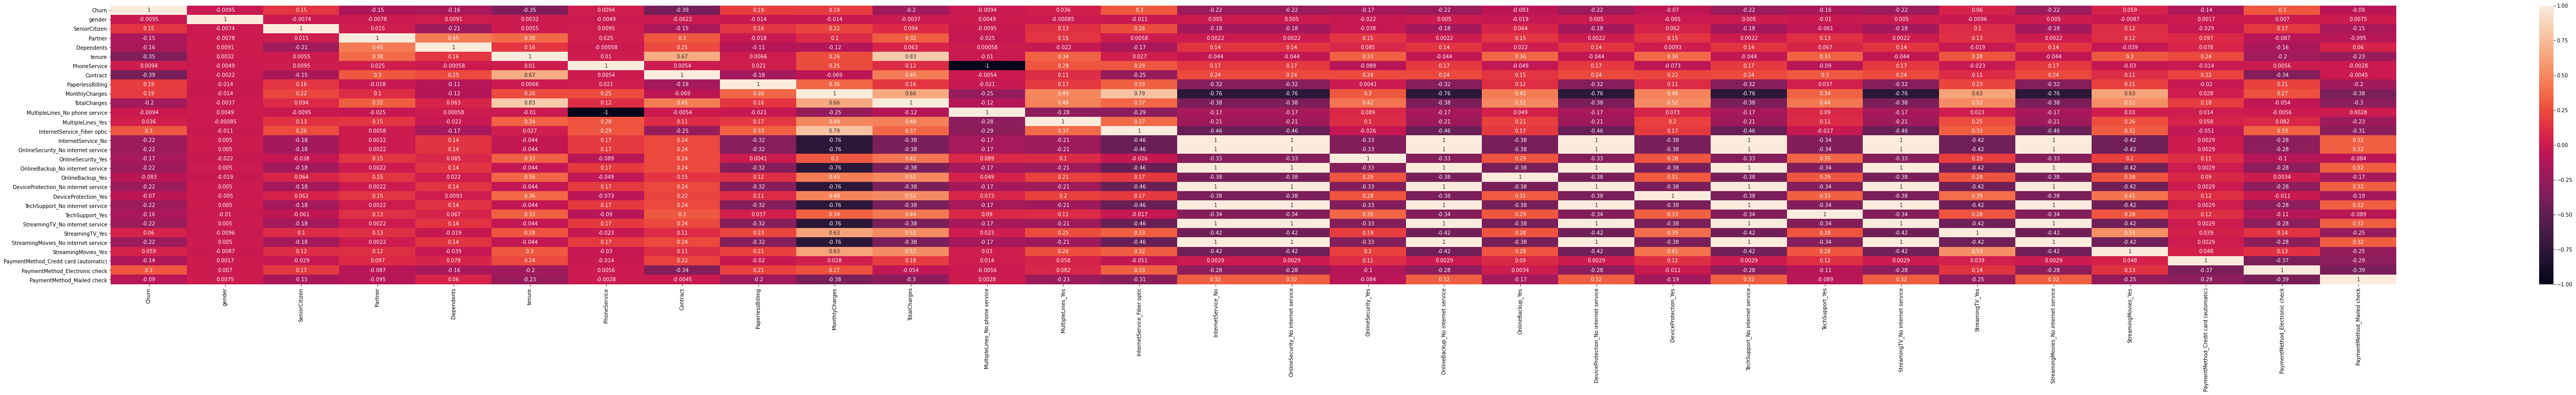

Columns of Strong interest: ['Churn', 'tenure', 'Contract', 'InternetService_Fiber optic'] 

Columns of Weaker interest: ['Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'Contract', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingMovies_No internet service', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check'] 



In [2]:
#correlate the dataframe pairwise to see which columns might be useful
corr=df.corr()

#plot the correlation to visualize the column pairings
plt.figure(figsize=(100,10))
sns.heatmap(corr, annot=True)
plt.show()

#Asolute values > .1 will be considered in our 
print(f"Columns of Strong interest: {corr[abs(corr['Churn']) > .3].index.tolist()} \n")
print(f"Columns of Weaker interest: {corr[abs(corr['Churn']) > .1].index.tolist()} \n")

<h2>Creating Test and Training data</h2>

Lifeted directly from the earlier project. 

In [3]:
#Creating X and y
data_df=df[['Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'Contract', 'PaperlessBilling', \
           'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'InternetService_No', \
           'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', \
           'DeviceProtection_No internet service', 'TechSupport_No internet service', 'TechSupport_Yes', \
           'StreamingTV_No internet service', 'StreamingMovies_No internet service', 'PaymentMethod_Credit card (automatic)',\
           'PaymentMethod_Electronic check']]
y=data_df['Churn']
X=data_df.drop(['Churn'], axis=1)

#Making sure the sizes remain consistent
if (X.shape[0] != y.shape[0]):
    print("Something is not right. The length of X and y are not the same")
else:
    print("Lengths match, we can continue")

#Creating the test and training data. We should be able to repeatedly do this in subsequent cells. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

Lengths match, we can continue


<h2>Models and Measuring Their Performance</h2>

Below are the original models I used as part of this project. For this tuning excercise, I have trimmed the LinearRegression model and the Keras Neural Network. 

In [52]:
def test_classifier(clas, X_train, y_train, X_test, y_test):
    '''
    Generic test to cut down on repetitive code 
    Inputs:
    clas - Instantiated classifier
    X_train, y_train, X_test, y_test - output from train_test_split for fitting and evaluating
    
    Output: None
    '''
    #Fit the model
    clas.fit(X_train, y_train)
    # Train the model
    y_predicts = clas.predict(X_test)
    
    # Evaluate and output reports
    print(f'Classification report for: {clas.__class__.__name__} \n \n {classification_report(y_test, y_predicts)} \n')
    # Print the options giving the best resuts. 
    print(f'score: {clas.score(X_test, y_test)} \n')
    # metrics.plot_confusion_matrix(clas, X_test, y_test, normalize='true')
    metrics.plot_confusion_matrix(clas, X_test, y_test)
    metrics.plot_roc_curve(clas, X_test, y_test)
    return

def test_tuning(clas, params, X_Train, y_train, X_test, y_test, verbose=2, cv=None):
    '''
    Generic tuning to cut down on repetitive code
    Inputs: 
        clas - classifier to be tested
        X_train, y_train, X_test, y_test - output from train_test_split for fitting and evaluating
        params - paramters passed to the GridSearch
    Outputs:
        returns the best, fitted classifier
    '''
    
    # Execute the Search
    clf = GridSearchCV(clas, params, n_jobs=-1, verbose=verbose, cv=cv)
    # clf = GridSearchCV(clas, params, scoring='precision_micro', n_jobs=-1, verbose=verbose, cv=cv)
    best = clf.fit(X_train, y_train).best_estimator_
    return(best, clf.best_params_, clf.best_score_)

<h3>Logistic Regression</h3>

This model is specifically built to handle a binary classification problem.

In [43]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

Classification report for: LogisticRegression 
 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       867
           1       0.68      0.56      0.61       331

    accuracy                           0.81      1198
   macro avg       0.76      0.73      0.74      1198
weighted avg       0.80      0.81      0.80      1198
 

score: 0.8055091819699499 

Fitting 30 folds for each of 84 candidates, totalling 2520 fits
Classification report for: LogisticRegression 
 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       867
           1       0.68      0.56      0.61       331

    accuracy                           0.80      1198
   macro avg       0.76      0.73      0.74      1198
weighted avg       0.80      0.80      0.80      1198
 

score: 0.8046744574290484 

best params: {'C': 8, 'class_weight': None, 'solver': 'lbfgs', 'warm_start': True} best score: 0.7970607932029476 



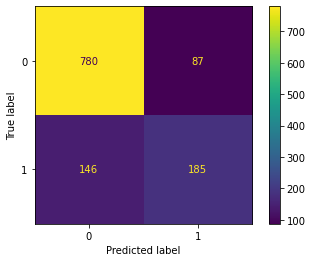

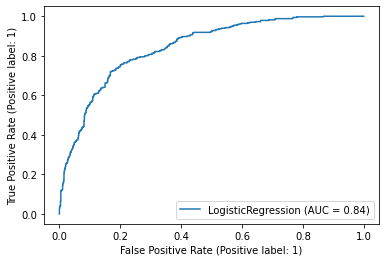

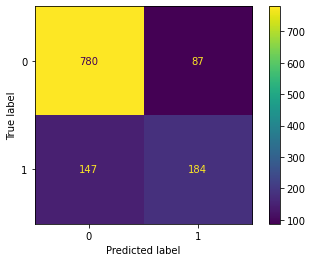

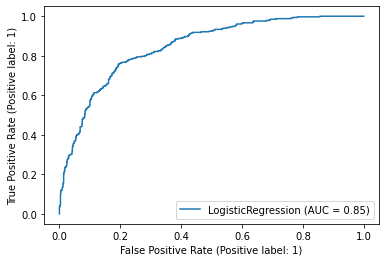

In [59]:
#Sending this to the test function to get our results
#
from scipy.stats import loguniform

# Original classifier with original results
test_classifier(LogisticRegression(solver='lbfgs', max_iter=10000, random_state=24),
                X_train, y_train, X_test, y_test)

# Setting up to do a a Grid Search
lr = LogisticRegression(max_iter=10000, random_state=24)
c_range = list(range(3, 10))

# Cross Validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Dictionary of paramters to feed to grid search
# {'C': 7, 'class_weight': None, 'solver': 'lbfgs', 'warm_start': True} best score: 0.7990781037645915 
# {'C': 3, 'class_weight': None, 'solver': 'lbfgs', 'warm_start': True} best score: 0.7990781037645915 
params = {'C':c_range,
# params = {'C':[3,5,7],
          'class_weight':['balanced', None],
          # 'multi_class':['auto', 'multinomial'],
          'solver':['lbfgs','newton-cg','sag'],
          'warm_start':[True, False],
         }

# Search for the best model, get the params for that model, and get the score for that model
best, best_params, best_score = test_tuning(lr, params, X_train, y_train, X_test, y_test, 2, cv)
# best, best_params, best_score = test_tuning(lr, params, X_train, y_train, X_test, y_test)

# Score the tuned classifier to compare against default parameters
test_classifier(best, X_train, y_train, X_test, y_test)

# Print the options giving the best resuts. 
print(f'best params: {best_params} best score: {best_score} \n')